# Titanic - Предсказание выживаемости пассажиров

- **Цель**: На основе данных о пассажирах (возраст, пол, класс билета и др.) предсказать, выжил ли человек.
- **Датасет**: [Titanic на Kaggle](https://www.kaggle.com/competitions/titanic)

## Загрузка и разведка данных (EDA)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Загрузка

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Быстрый анализ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Распределение целевой переменной

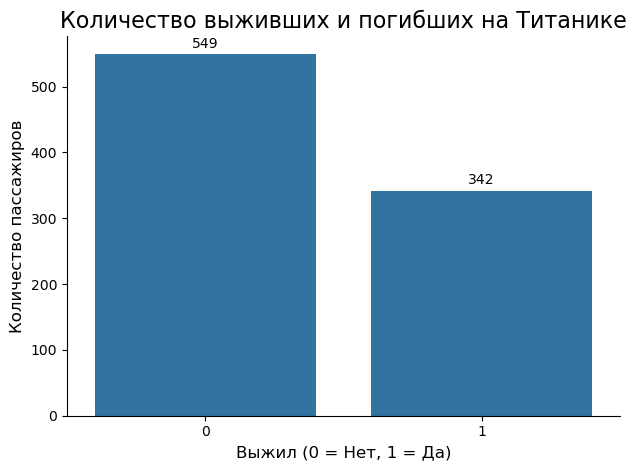

In [6]:
ax = sns.countplot(x='Survived', data=df)

ax.set_title('Количество выживших и погибших на Титанике', fontsize=16)
ax.set_xlabel('Выжил (0 = Нет, 1 = Да)', fontsize=12)
ax.set_ylabel('Количество пассажиров', fontsize=12)

# Отображение значений над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height + 5),
                ha='center', va='bottom', fontsize=10)

# Настройка стиля
sns.despine()  # Убирает рамки справа и сверху
plt.tight_layout()
plt.show()

### Пол, возраст, класс

<Axes: xlabel='Sex', ylabel='count'>

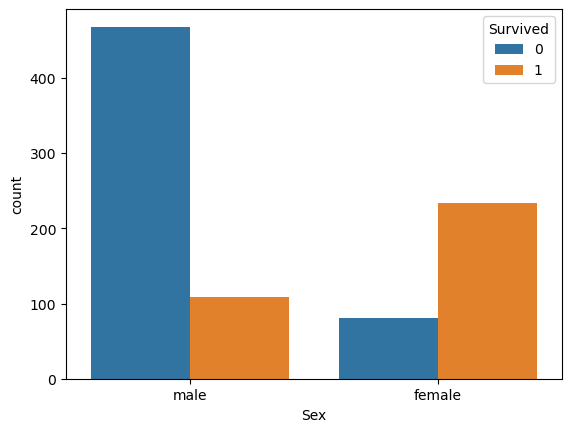

In [7]:
#Пол
sns.countplot(x='Sex', hue='Survived', data=df)

<Axes: xlabel='Age', ylabel='Count'>

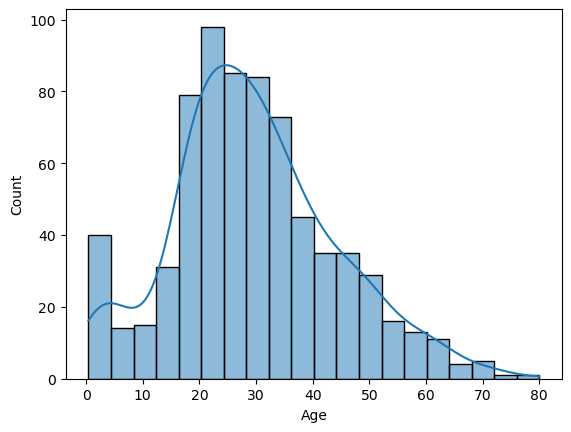

In [8]:
# Возраст
sns.histplot(df['Age'].dropna(), kde=True)


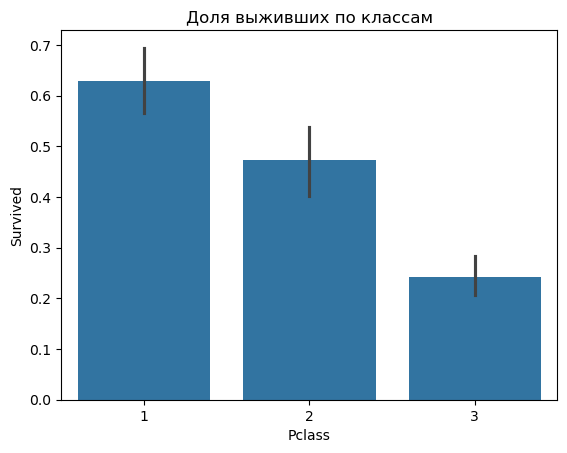

In [9]:
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title("Доля выживших по классам")
plt.show()

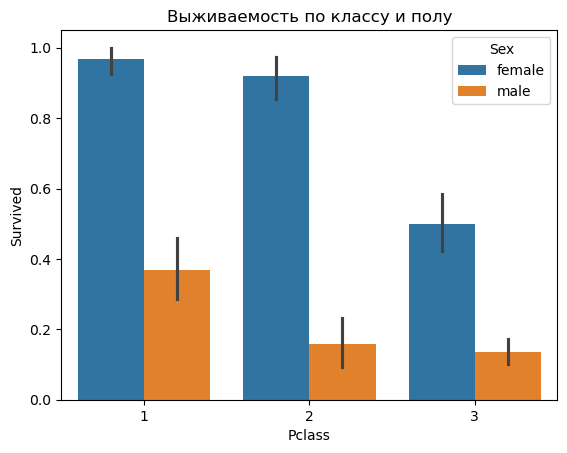

In [10]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)
plt.title("Выживаемость по классу и полу")
plt.show()

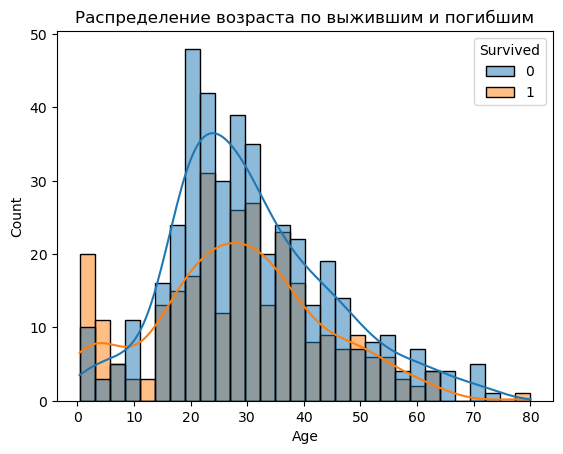

In [11]:
sns.histplot(x='Age', hue='Survived', data=df, bins=30, kde=True)
plt.title("Распределение возраста по выжившим и погибшим")
plt.show()

### Вывод:
- Больше шансов выжить у 1-го класса и женщин.
- Дети до 10 лет выживали чаще.
- Билеты 1-го класса дороже и менее разбросаны по цене.

## Предобработка данных

### Заполнение пропущенных значений возраста медианой (устойчиво к выбросам)

In [12]:
df['Age'] = df['Age'].fillna(df['Age'].median())

### Заполнение пропущенных значений порта посадки наиболее частым значением

In [13]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

### Кодирование категориальных признаков
#### Преобразуем пол: male -> 0, female -> 1

In [14]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

#### Применяем one-hot encoding к порту посадки (Embarked), исключая первый столбец

In [15]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

### Создание новых признаков
#### Общее число родственников на борту (братья/сёстры + родители/дети)


Создаётся новый столбец **FamilySize**, который показывает, сколько у пассажира было родственников на борту.

- SibSp — количество братьев/сестёр и супругов

- Parch — количество родителей и детей

In [16]:
df['FamilySize'] = df['SibSp'] + df['Parch']

💡 **Идея**: Пассажиры, которые путешествуют с семьёй, могли иметь выше шансы на выживание (или наоборот).

#### Путешествовал один или с семьей
Создаётся булевый признак IsAlone, который равен 1, если пассажир путешествовал один, и 0 — если с семьёй.
- True → 1
- False → 0 (с помощью .astype(int))

In [17]:
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

💡 **Идея**: Одинокий пассажир мог иметь меньше шансов на помощь или защиту.

#### Обращение к пассажиру (Титулы)

In [18]:
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
# Приводим титулы к единому виду (объединяем эквиваленты)
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Royalty',
    'Countess': 'Royalty',
    'Dona': 'Royalty',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Don': 'Noble',
    'Sir': 'Noble',
    'Jonkheer': 'Noble'
})
# Проверка на редкие титулы — заменяем редкие на 'Rare'
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# Преобразуем текстовые значения в числа через one-hot encoding (убираем один столбец, чтобы избежать мультиколлинеарности)
df = pd.get_dummies(df, columns=['Title'], drop_first=True)

#### Возрастные группы

In [19]:
df['AgeGroup'] = pd.cut(
    df['Age'], 
    bins=[0, 12, 18, 35, 60, 100], 
    labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
)

Объяснение:

`pd.cut()` разбивает числовое значение `Age` на интервалы (bins).

Интервалы:

- 0–12 → Child

- 13–18 → Teen

- 19–35 → YoungAdult

- 36–60 → Adult

- 61–100 → Senior

**Результат** — новая колонка `AgeGroup` с текстовыми метками.

In [20]:
df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

Объяснение:
- **One-hot кодирование**: создаются бинарные признаки `AgeGroup_Teen`, `AgeGroup_YoungAdult`, и т.д.
- `drop_first=True` — убирает первую категорию (`Child`), чтобы избежать мультиколлинеарности.

✅ Результат:
- Допустим, `Age = 27 → AgeGroup = 'YoungAdult'` → добавится колонка `AgeGroup_YoungAdult = 1`

#### Создание бинарного признака: есть ли информация о каюте

In [21]:
df['HasCabin'] = df['Cabin'].notnull().astype(int)

📌 **Зачем:** наличие/отсутствие каюты связано с классом и выживаемостью, и это полезный бинарный признак.

#### Удаление неинформативных колонок

In [22]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

📌 Зачем:
- Name — после извлечения Title больше не нужен.
- Ticket, Cabin — слишком разреженные и неинформативные.
- PassengerId — идентификатор, не используется моделью.

### Выбор признаков

Определяем набор признаков, по которым будет обучаться модель.

In [23]:
# Обновим список признаков (включаем все колонки, начинающиеся с 'Title_')
title_features = [col for col in df.columns if col.startswith('Title_')]
agegroup_features = [col for col in df.columns if col.startswith('AgeGroup_')]
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'HasCabin'] + title_features + agegroup_features

🔹 Отбирает из DataFrame ``df`` только нужные признаки → ``X`` будет матрицей признаков для обучения.

In [24]:
X = df[features]

🔹 Определяем целевую переменную y, которую модель будет предсказывать:
- 0 — не выжил
- 1 — выжил

In [25]:
y = df['Survived']

## Обучение моделей

### Train/Test Split

In [26]:
from sklearn.model_selection import train_test_split

Разделение данных на обучающую и тестовую выборки:

- X: матрица признаков (например: пол, возраст, стоимость билета и т.д.)
- y: целевая переменная (Survived — выжил или нет)
- test_size=0.2: 20% данных пойдут в тестовую выборку, 80% — на обучение
- random_state=42: фиксируем "случайность", чтобы результат был воспроизводимым

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Логистическая регрессия (базовая модель)

Что делает логистическая регрессия?
- Она оценивает вероятность принадлежности объекта к классу 1 (в нашем случае — выжил).
- По сути, это линейная модель, но с использованием логистической функции (сигмоида), чтобы результат всегда был от 0 до 1.

In [28]:
from sklearn.linear_model import LogisticRegression

Создаём модель логистической регрессии
- max_iter=1000 — максимальное количество итераций для сходимости алгоритма (по умолчанию 100, может быть мало при плохой масштабировке признаков)

In [29]:
lr = LogisticRegression(max_iter=1000)

Обучаем модель на тренировочных данных (признаки и целевая переменная)

In [30]:
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [31]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test)
print("Точность логистической регрессии:", accuracy_score(y_test, y_pred))

Точность логистической регрессии: 0.8100558659217877


💡 **Вывод:**
* Базовая модель работает неплохо.
* Простая, интерпретируемая.
* Может быть чувствительна к масштабу данных и выбросам.

### Случайный лес

- Строит множество решающих деревьев на разных подмножествах данных и признаков.
- Каждый отдельный "дерево-эксперт" голосует за класс, и большинство голосов побеждает.
- Обеспечивает устойчивость к переобучению и высокую точность.

In [32]:
from sklearn.ensemble import RandomForestClassifier  # Импорт классификатора случайного леса

Создаём модель случайного леса:
- n_estimators=100 — количество деревьев в лесу (больше = устойчивее, но медленнее)
- random_state=42 — фиксируем случайность для воспроизводимости

In [33]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

Обучаем модель на тренировочных данных

In [34]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost (градиентный бустинг на решающих деревьях)

📌 Что делает XGBoost?

Это алгоритм градиентного бустинга, который строит деревья последовательно — каждое новое дерево учится исправлять ошибки предыдущих.

- Очень точный, быстрый и эффективный, особенно на табличных данных.
- Использует регуляризацию, раннюю остановку и множество параметров, чтобы предотвратить переобучение.

In [35]:
from xgboost import XGBClassifier  # Импорт классификатора XGBoost
from sklearn.metrics import accuracy_score

🔧 Создаём модель XGBoost:
- n_estimators=100 — количество деревьев (как и в случайном лесе)
- learning_rate=0.1 — скорость обучения (влияет на вклад каждого дерева)
- use_label_encoder=False — отключаем предупреждение
- eval_metric='logloss' — метрика для обучения (логарифмическая потеря)
- random_state=42 — фиксируем случайность

In [36]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

🧠 Обучаем модель на тренировочных данных:

In [37]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


📈 Оцениваем точность на тестовой выборке:

y_pred = xgb.predict(X_test)
print("Точность XGBoost:", accuracy_score(y_test, y_pred))

🧩 Преимущества XGBoost:
+ Более гибкий, чем RandomForest — можно настраивать скорость, глубину, регуляризацию.
+ Часто выигрывает в соревнованиях по машинному обучению (Kaggle).
+ Устойчив к пропущенным данным, дисбалансу классов, переобучению.

### Ансамбль моделей

In [38]:
from sklearn.ensemble import VotingClassifier

Создание базовых моделей

lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

Ансамбль моделей — голосование на основе вероятностей (soft voting)

In [39]:
voting = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'  # soft — учитываются вероятности; hard — голоса
)

 Обучаем ансамбль на тренировочных данных

In [40]:
voting.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


### Оценка

Метрики оценки классификации

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

#### Оценка модели - Логическая регрессия

Предсказания на тестовой выборке

In [42]:
y_pred = lr.predict(X_test)

Матрица ошибок (confusion matrix)

In [43]:
print(confusion_matrix(y_test, y_pred))

[[88 17]
 [17 57]]


In [44]:
# Полный отчёт: precision, recall, f1-score, accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



#### Оценка модели - Случайный лес

Предсказания на тестовой выборке

In [45]:
y_pred = rf.predict(X_test)

Матрица ошибок (confusion matrix)

In [46]:
print(confusion_matrix(y_test, y_pred))

[[89 16]
 [18 56]]


|                   | **Факт: 0 (не выжил)** | **Факт: 1 (выжил)** |
| ----------------- | ---------------------- | ------------------- |
| **Предсказал: 0** | 90 (TN)                | 15 (FN)             |
| **Предсказал: 1** | 17 (FP)                | 57 (TP)             |

- **TN (True Negative)** = 90 — правильно предсказали, что не выжил

- **TP (True Positive)** = 57 — правильно предсказали, что выжил

- **FP (False Positive)** = 17 — ошибочно предсказали "выжил", а человек погиб

- **FN (False Negative)** = 15 — ошибочно предсказали "погиб", а человек выжил

In [47]:
# Полный отчёт: precision, recall, f1-score, accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



| Метрика          | Что означает                                                        |
| ---------------- | ------------------------------------------------------------------- |
| **precision**    | Доля **корректных положительных предсказаний** (TP / (TP + FP))     |
| **recall**       | Доля **реально выживших, которых модель нашла** (TP / (TP + FN))    |
| **f1-score**     | Среднее гармоническое между precision и recall                      |
| **support**      | Количество объектов в каждом классе (реальных)                      |
| **accuracy**     | Общая точность (все верные / общее количество)                      |
| **macro avg**    | Среднее значение метрик по классам (не учитывает дисбаланс классов) |
| **weighted avg** | Средневзвешенное по количеству в каждом классе                      |

📌 Выводы:
- Матрица ошибок показывает, где именно модель ошибается (что путает).
- classification_report — более подробный анализ качества по каждому классу.
- Для задачи с неравномерным классом (например, много погибших и меньше выживших) важнее f1-score и recall, чем просто accuracy.

#### Оценка модели XGBoost

In [48]:
y_pred_xgb = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))

[[86 19]
 [18 56]]


In [49]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       105
           1       0.75      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



#### Оценка ансамбля моделей

In [50]:
y_pred_voting = voting.predict(X_test)

In [51]:
# Метрики точности
print("🔍 Точность ансамбля моделей:", accuracy_score(y_test, y_pred_voting))

print("\n📊 Матрица ошибок:")
print(confusion_matrix(y_test, y_pred_voting))

print("\n📄 Отчёт по метрикам:")
print(classification_report(y_test, y_pred_voting))

🔍 Точность ансамбля моделей: 0.8268156424581006

📊 Матрица ошибок:
[[91 14]
 [17 57]]

📄 Отчёт по метрикам:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### Кросс-валидация моделей

**Кросс-валидация (cross-validation)** — метод, позволяющий получить более надёжную оценку качества модели.
Обычно используется k-fold кросс-валидация (чаще всего k=5 или 10).

🔧 Суть:
- Данные делятся на k равных частей.
- Модель обучается k раз, каждый раз — на k-1 частях, а тестируется на оставшейся.
- В итоге получаем k оценок точности, и считаем среднее.

In [52]:
from sklearn.model_selection import cross_val_score
import numpy as np

#### Кросс-валидация для логистической регрессии

In [53]:
lr_scores = cross_val_score(
    lr,             # модель
    X_train,        # обучающие признаки
    y_train,        # обучающие метки
    cv=5,           # количество фолдов
    scoring='accuracy'  # метрика
)

print("Оценки логистической регрессии (5-Fold CV):", lr_scores)
print("Средняя точность:", np.mean(lr_scores))

Оценки логистической регрессии (5-Fold CV): [0.84615385 0.83916084 0.83098592 0.78873239 0.83802817]
Средняя точность: 0.828612232837585


#### Кросс-валидация для случайного леса

In [54]:
rf_scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Оценки случайного леса (5-Fold CV):", rf_scores)
print("Средняя точность:", np.mean(rf_scores))

Оценки случайного леса (5-Fold CV): [0.81118881 0.7972028  0.79577465 0.78169014 0.81690141]
Средняя точность: 0.8005515611149414


#### Кросс-валидация для XGBoost

In [55]:
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

xgb_scores = cross_val_score(
    xgb,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Оценки XGBoost (5-Fold CV):", xgb_scores)
print("Средняя точность:", np.mean(xgb_scores))

Оценки XGBoost (5-Fold CV): [0.79020979 0.7972028  0.79577465 0.8028169  0.78873239]
Средняя точность: 0.7949473062149119


#### Кросс-валидация для ансамбля моделей (VotingClassifier)

In [56]:
# Объявляем модели заново, если нужно
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Создаём ансамбль
voting = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_scores = cross_val_score(
    voting,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Оценки ансамбля моделей (5-Fold CV):", voting_scores)
print("Средняя точность:", np.mean(voting_scores))

Оценки ансамбля моделей (5-Fold CV): [0.84615385 0.83216783 0.80985915 0.85211268 0.85211268]
Средняя точность: 0.8384812370727864


##  Подбор гиперпараметров

### Логистическая регрессия

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [58]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Регуляризация
    'penalty': ['l2'],        # Тип регуляризации
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='accuracy'
)

grid_lr.fit(X_train, y_train)

print("Лучшая точность LogisticRegression:", grid_lr.best_score_)
print("Лучшие параметры LogisticRegression:", grid_lr.best_params_)

Лучшая точность LogisticRegression: 0.828612232837585
Лучшие параметры LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


### Случайный лес

In [59]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy'
)

grid_rf.fit(X_train, y_train)

print("Лучшая точность RandomForest:", grid_rf.best_score_)
print("Лучшие параметры RandomForest:", grid_rf.best_params_)

Лучшая точность RandomForest: 0.839840441248892
Лучшие параметры RandomForest: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}


###  XGBoost

In [60]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='accuracy'
)

grid_xgb.fit(X_train, y_train)

print("Лучшая точность XGBoost:", grid_xgb.best_score_)
print("Лучшие параметры XGBoost:", grid_xgb.best_params_)

Лучшая точность XGBoost: 0.8384615384615384
Лучшие параметры XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


### Ансамбль из лучших моделей

In [61]:
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

In [62]:
from sklearn.ensemble import VotingClassifier

voting_optimized = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

voting_optimized.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred_ens = voting_optimized.predict(X_test)

print("Точность ансамбля с подобранными параметрами:", accuracy_score(y_test, y_pred_ens))

Точность ансамбля с подобранными параметрами: 0.8100558659217877


### Оценка ансамбля с лучшими параметрами моделей

Делаю предсказания

In [63]:
y_pred = voting_optimized.predict(X_test)
y_prob = voting_optimized.predict_proba(X_test)[:, 1]  # Для ROC AUC

Считаю метрики

- **Accuracy** — точность модели по всем предсказаниям
- **Precision** — точность по классу 1 (выжил)
- **Recall** — полнота (модель нашла всех выживших?)
- **F1-score** — баланс между precision и recall
- **ROC AUC** — качество разделения классов
- **Матрицу ошибок** — где модель ошибается

Accuracy: 0.8100558659217877
Precision: 0.7857142857142857
Recall: 0.7432432432432432
F1 Score: 0.7638888888888888
ROC AUC: 0.8902187902187901

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



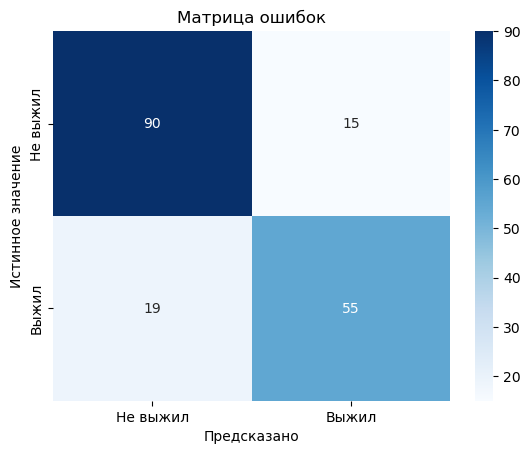

In [64]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Полный отчёт
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Не выжил", "Выжил"], yticklabels=["Не выжил", "Выжил"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.show()

## Сохранение обученной модели

In [65]:
import joblib

joblib.dump(voting_optimized, 'voting_optimized.pkl')
print("✅ Модель успешно сохранена в файл 'voting_optimized.pkl'")

✅ Модель успешно сохранена в файл 'voting_optimized.pkl'
